In [1]:
import argparse
import sys

import torch
from torch import nn

from data import mnist
from data import CustomTensorDataset
from model import MyAwesomeModel
import torch
from matplotlib import pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = MyAwesomeModel()
model = model.to(device)
(X_train, y_train), (X_test, y_test) = mnist()

train_dataset_normal = CustomTensorDataset(tensors=(X_train, y_train), transform=None)
trainloader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16)

test_dataset_normal = CustomTensorDataset(tensors=(X_test, y_test), transform=None)
testloader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()   

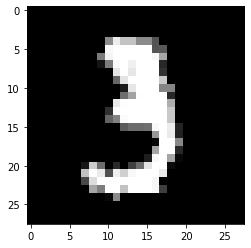

In [5]:
images, labels = next(iter(trainloader))
plt.imshow(images[10].numpy().squeeze(), cmap='Greys_r');

In [4]:
epochs = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move to GPU for acceleration
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():   
            # images, labels = next(iter(testloader))
            images, labels = X_test.to(device), y_test.to(device)
            ps = torch.exp(model(images))
            acc = torch.eq(labels.argmax(1), ps.argmax(1)).sum() / labels.size(0)
                
        print(f'Accuracy: {acc.item()}, running_loss {running_loss}')

Accuracy: 0.11419999599456787, running_loss 3596.9889104366302
Accuracy: 0.11419999599456787, running_loss 3596.431107521057
Accuracy: 0.11419999599456787, running_loss 3596.4422175884247
Accuracy: 0.11419999599456787, running_loss 3596.444270133972
Accuracy: 0.11419999599456787, running_loss 3596.444499731064
Accuracy: 0.11419999599456787, running_loss 3596.444516658783
Accuracy: 0.11419999599456787, running_loss 3596.444525718689


KeyboardInterrupt: 

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

NameError: name 'equals' is not defined

The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [ ]:
model = Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move to GPU for acceleration
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                ps = torch.exp(model(images))

                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                break
        print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 82.8125%
Accuracy: 89.0625%
Accuracy: 92.1875%
Accuracy: 89.0625%
Accuracy: 89.0625%


## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [ ]:
## TODO: Define your model with dropout added
class ClassifierDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
model = nn.Sequential(
    nn.Conv2d(1,16,5),
    nn.ReLU(),
    nn.Conv2d(16,8,5),
    nn.ReLU(),
    nn.Conv2d(8,4,5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024,10),
    nn.LogSoftmax(dim=1)
)
model.to(device)
model(images).shape, images.shape
# model = ClassifierDropout()

(torch.Size([64, 10]), torch.Size([64, 1, 28, 28]))

In [ ]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 2
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move to GPU for acceleration
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                ps = torch.exp(model(images))

                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                break
        print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 92.1875%
Accuracy: 90.625%


## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

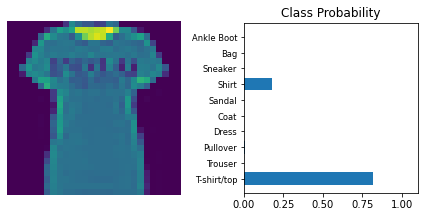

In [ ]:
# Import helper module (should be in the repo)
import helper
import random
cpu = torch.device("cpu")
# Test out your network!

model.eval()
model.cpu()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[random.randint(1, 20)]
# Convert 2D image to 1D vector
img = img.view(1, *img.shape)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
ps.cpu()
# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.